In [1]:
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from collections import Counter
import numpy as np
import warnings
warnings.filterwarnings("ignore")
#Tp ignore python warnings
import pytz
from datetime import datetime
from pytz import timezone
from zipline.api import order, symbol, symbols, record, order_target, history , schedule_function
from zipline.utils.events import date_rules
'''
order() takes 2 arguments : i) a security object ii) no. of shares you want to buy
record() helps you to save values of variables at each iteration
'''
from zipline.algorithm import TradingAlgorithm
from zipline.utils.factory import load_bars_from_yahoo
#from zipline import run_algorithm
import matplotlib.pyplot as plt

In [2]:
assign_stock = ['AAPL']
start = datetime(2015,12,1,0,0,0,0, pytz.utc).date()
end = datetime(2016,12,1,0,0,0,0, pytz.utc).date()
#data = load_bars_from_yahoo(stocks=['SPY'], start=start,end=end)
input_data = load_bars_from_yahoo(stocks=assign_stock, start=start,end=end)
print input_data.minor_axis
#input_data['AAPL'].iloc[1:10]
input_data['AAPL']['price'][:10]

Index([u'open', u'high', u'low', u'close', u'volume', u'price'], dtype='object')


Date
2015-12-01 00:00:00+00:00    114.786099
2015-12-02 00:00:00+00:00    113.749172
2015-12-03 00:00:00+00:00    112.692677
2015-12-04 00:00:00+00:00    116.439319
2015-12-07 00:00:00+00:00    115.705642
2015-12-08 00:00:00+00:00    115.656735
2015-12-09 00:00:00+00:00    113.103541
2015-12-10 00:00:00+00:00    113.641566
2015-12-11 00:00:00+00:00    110.716645
2015-12-14 00:00:00+00:00    110.031884
Name: price, dtype: float64

In [3]:
def initialize(context):
    #schedule_function(myfunc,date_rules.every_day())
    #time_rules.market_open(minutes=1))
    context.stocks = symbol('AAPL')
    context.i = 0
    context.historical_bars = 100
    #we'll use it as 100d training data
    context.feature_window = 10
    #we'll use it as features to our model

In [4]:

def myfunc(context, data):
    if context.i < 100:
        context.i += 1
        return
    context.i += 1
    prices = data.history(context.stocks,'price',context.historical_bars,'1d')
    #storing last 100d data
    #'price' is the adj_close price
    prices_low = data.history(context.stocks,'low',context.historical_bars,'1d')
    prices_high = data.history(context.stocks,'high',context.historical_bars,'1d')
    prices_volume = data.history(context.stocks,'volume',context.historical_bars,'1d')
    try:
        current_price = data.current(context.stocks,'price')
        current_positions = context.portfolio.positions[symbol('AAPL')].amount
        cash = context.portfolio.cash
        value = context.portfolio.portfolio_value
        current_pnl = context.portfolio.pnl
        start_bar = context.feature_window
        price_list = prices
        high_list = prices_high
        low_list = prices_low
        vol_list = prices_volume
        X = []
        y = []
        bar = start_bar
        while bar < len(price_list)-1:
            #putting the 100d prices in the loop and using the results of this examples to built the model
            try:
                end_price = price_list[bar+1]
                #end_price is the price that you are predicting for 100d sample
                begin_price = price_list[bar]
                #begin_price : previous adj_close price
                pricing_list = []
                xx = 0
                for _ in range(context.feature_window):
                    # '_' when we are not gonna use the for loop variable
                    price = price_list[bar-(context.feature_window-xx)]
                    pricing_list.append(price)
                    xx += 1
                features = np.around(np.diff(pricing_list) / pricing_list[:-1] * 100.0, 2)
                features = np.append(features,np.around(high_list[bar-1]/price_list[bar-1],2))
                features = np.append(features,np.around(low_list[bar-1]/price_list[bar-1],2))
                features = np.append(features,vol_list[bar-1]/100000)
                if end_price > begin_price:
                    label = 1
                else:
                    label = -1
                bar += 1
                X.append(features)
                #adding features to X
                y.append(label)
                #adding corresponding labels to Y
            except Exception as e:
                bar += 1
                print(('feature creation',str(e)))
        clf = SVC(kernel='rbf', C = 1000, gamma=10,probability=True)
        last_prices = price_list[-context.feature_window:]
        current_features = np.around(np.diff(last_prices) / last_prices[:-1] * 100.0,2)
        #normalizing the prices
        current_features = np.append(current_features,np.around(high_list[-1]/price_list[-1],2))
        current_features = np.append(current_features,np.around(low_list[-1]/price_list[-1],2))
        current_features = np.append(current_features,vol_list[-1]/100000)
        clf.fit(X,y)
        p = clf.predict(current_features)[0]
        if p == 1 and current_positions == 0:
            #print 'buy'
            ##buy the shares if you didn't have buy it already
            number_of_shares = int(cash/current_price)
            order(context.stocks, number_of_shares)
            record(Price=
                   current_price,status="buy",PnL=current_pnl,cash=cash)
        elif p == -1 and current_positions != 0:
            #print 'sell'
            order_target(context.stocks, 0)
            record(Price=
                   current_price,status="sell",PnL=current_pnl,cash=cash)
        else:
            #print 'else'
            record(Price=
                   current_price,status="--",PnL=current_pnl,cash=cash)
    except Exception as e:
        #return
        print(str(e))
        

In [5]:
algo_obj = TradingAlgorithm(initialize=initialize,handle_data=myfunc,capital_base=80000)
#By defualt capital = 100000
perf_manual = algo_obj.run(input_data)

In [28]:
perf_manual[['Price','status']][(perf_manual['status']=='buy')|(perf_manual['status']=='sell')]

,Price,status
2016-04-26 20:00:00,102.632739,buy
2016-05-06 20:00:00,91.749363,sell
2016-05-09 20:00:00,91.818630,buy
2016-07-26 20:00:00,95.658010,sell
2016-07-27 20:00:00,101.872267,buy
2016-08-18 20:00:00,108.522821,sell
2016-08-23 20:00:00,108.293993,buy
2016-08-25 20:00:00,107.020532,sell
2016-08-31 20:00:00,105.558040,buy
2016-11-14 21:00:00,105.709999,sell


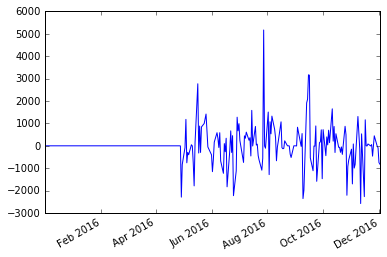

In [29]:
perf_manual['pnl'].plot()

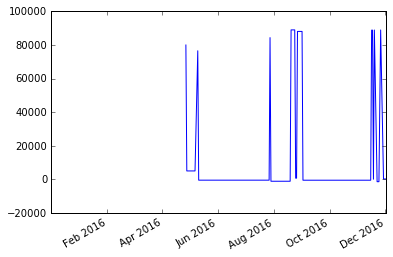

In [30]:
perf_manual['cash'].plot()

In [31]:

def myfunc(context, data):
    if context.i < 100:
        context.i += 1
        return
    context.i += 1
    prices = data.history(context.stocks,'price',context.historical_bars,'1d')
    #storing last 100d data
    #'price' is the adj_close price
    prices_low = data.history(context.stocks,'low',context.historical_bars,'1d')
    prices_high = data.history(context.stocks,'high',context.historical_bars,'1d')
    prices_volume = data.history(context.stocks,'volume',context.historical_bars,'1d')
    try:
        current_price = data.current(context.stocks,'price')
        current_positions = context.portfolio.positions[symbol('AAPL')].amount
        cash = context.portfolio.cash
        value = context.portfolio.portfolio_value
        current_pnl = context.portfolio.pnl
        start_bar = context.feature_window
        price_list = prices
        high_list = prices_high
        low_list = prices_low
        vol_list = prices_volume
        X = []
        y = []
        bar = start_bar
        while bar < len(price_list)-1:
            #putting the 100d prices in the loop and using the results of this examples to built the model
            try:
                end_price = price_list[bar+1]
                #end_price is the price that you are predicting for 100d sample
                begin_price = price_list[bar]
                #begin_price : previous adj_close price
                pricing_list = []
                xx = 0
                for _ in range(context.feature_window):
                    # '_' when we are not gonna use the for loop variable
                    price = price_list[bar-(context.feature_window-xx)]
                    pricing_list.append(price)
                    xx += 1
                features = np.around(np.diff(pricing_list) / pricing_list[:-1] * 100.0, 2)
                features = np.append(features,np.around(high_list[bar-1]/price_list[bar-1],2))
                features = np.append(features,np.around(low_list[bar-1]/price_list[bar-1],2))
                features = np.append(features,vol_list[bar-1]/100000)
                
                if end_price > begin_price:
                    label = 1
                else:
                    label = -1
                bar += 1
                X.append(features)
                #adding features to X
                y.append(label)
                #adding corresponding labels to Y
            except Exception as e:
                bar += 1
                print(('feature creation',str(e)))
        clf = RandomForestClassifier()
        last_prices = price_list[-context.feature_window:]
        current_features = np.around(np.diff(last_prices) / last_prices[:-1] * 100.0,2)
        current_features = np.append(current_features,np.around(high_list[-1]/price_list[-1],2))
        current_features = np.append(current_features,np.around(low_list[-1]/price_list[-1],2))
        current_features = np.append(current_features,vol_list[-1]/100000)
        #normalizing the prices
        clf.fit(X,y)
        #acc = metrics.accuracy_score(y_test, clf.predict(X_test))
        #scores = cv.cross_val_score(clf, X, y, cv=4)
        p = clf.predict(current_features)[0]
        if p == 1 and current_positions == 0:
            #print 'buy'
            ##buy the shares if you didn't have buy it already
            number_of_shares = int(cash/current_price)
            order(context.stocks, number_of_shares)
            record(Price=
                   current_price,status="buy",PnL=current_pnl,cash=cash)
        elif p == -1 and current_positions != 0:
            #print 'sell'
            order_target(context.stocks, 0)
            record(Price=
                   current_price,status="sell",PnL=current_pnl,cash=cash)
        else:
            #print 'else'
            record(Price=
                   current_price,status="--",PnL=current_pnl,cash=cash)
    except Exception as e:
        #return
        print(str(e))

In [32]:
algo_obj = TradingAlgorithm(initialize=initialize,handle_data=myfunc,capital_base=80000)
#By defualt capital = 100000
perf_manual = algo_obj.run(input_data)

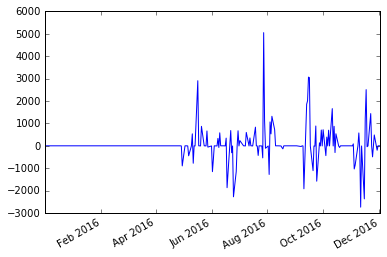

In [33]:
perf_manual['pnl'].plot()

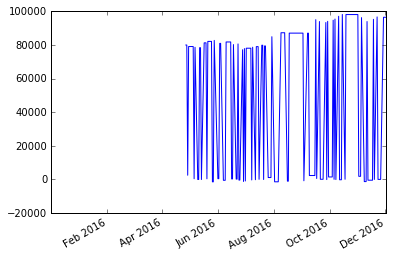

In [34]:
perf_manual['cash'].plot()

In [35]:
perf_manual[['Price','status']][(perf_manual['status']=='buy')|(perf_manual['status']=='sell')]

,Price,status
2016-04-27 20:00:00,96.210203,buy
2016-04-28 20:00:00,93.269411,sell
2016-05-04 20:00:00,92.639944,buy
2016-05-05 20:00:00,92.263917,sell
2016-05-06 20:00:00,91.749363,buy
2016-05-10 20:00:00,92.442033,sell
2016-05-12 20:00:00,89.394274,buy
2016-05-13 20:00:00,89.572390,sell
2016-05-18 20:00:00,93.570098,buy
2016-05-19 20:00:00,93.213866,sell
